In [48]:
import torch
from torch import nn
from torch.nn import functional as F
import pandas as pd
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np


from sklearn.metrics import confusion_matrix

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device is", device)

classes = ('g','r','n')

device is cpu


In [49]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [50]:
# image: input size 128x64
# out: one-hot [Green, Red, None]
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.act = nn.ReLU()
        self.sig = nn.Softmax()
        
        # input: 256x128x3
        self.conv11 = nn.Conv2d(3, 6, kernel_size=3, padding=0) # output: 254x126x6
        self.conv12 = nn.Conv2d(6, 6, kernel_size=3, padding=0) # output: 252x124x6
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)      # output: 176x62x6

        self.conv21 = nn.Conv2d(6, 3, kernel_size=3, padding=0) # output: 174x60x3
        self.conv22 = nn.Conv2d(3, 1, kernel_size=3, padding=0) # output: 172x58x1
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)      # output: 86x29x1

        self.fc1 = nn.Linear(1769,500)
        self.fc2 = nn.Linear(500,3)
    
    def forward(self, x):
        x = self.conv11(x)
        x = self.act(x)
        x = self.conv12(x)
        x = self.act(x)
        x = self.pool1(x)

        x = self.conv21(x)
        x = self.act(x)
        x = self.conv22(x)
        x = self.act(x)
        x = self.pool2(x)

        x = torch.flatten(x,start_dim=1)

        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)

        out = self.sig(x)
        return out

In [51]:
class CaptionDataset(torch.utils.data.Dataset):
    def __init__(self, dir, transform=None):
        self.image_dir = os.path.join(dir,"Images")
        self.df = pd.read_csv(os.path.join(dir,"labels.txt"))
        self.transform = transform

    def __getitem__(self,i,transform=None):              
        label = self.df["label"][i]
        if label=="g":
            label = torch.tensor([1,0,0])
        if label=="r":
            label = torch.tensor([0,1,0])
        if label=="n":
            label = torch.tensor([0,0,1])
        image_path = os.path.join(self.image_dir,self.df["image"][i])
        image = transforms.ToTensor()(Image.open(image_path))
        if self.transform!=None:
            image = self.transform(image)
        return (image,label)

    def __len__(self):
        return len(self.df)

In [52]:
transform = transforms.Compose([
    transforms.Resize((128,256))
])

In [53]:
ds = CaptionDataset("data", transform=transform)

train_size = int(0.7 * len(ds))
val_size = int(0.15 * len(ds))
test_size = len(ds) - train_size - val_size

train_set, val_set, test_set = torch.utils.data.random_split(ds, [train_size, val_size, test_size])

train_loader = DataLoader(train_set,batch_size=16)
val_loader = DataLoader(val_set,batch_size=16)
test_loader = DataLoader(test_set,batch_size=16)
it = iter(train_loader)

tensor([0, 0, 1])


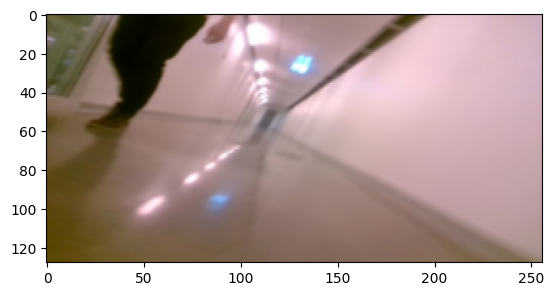

In [54]:
(images,labels) = next(it)
plt.imshow(images[1].permute(1, 2, 0))
print(labels[1])

In [55]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs):
    best_val_loss = float('inf')
    best_model = model

    for epoch in range(num_epochs):
        print(f"Starting epoch {epoch+1} of {num_epochs}")
        model.train()
        train_loss = 0.0
        for batch_nr, (inputs, labels) in enumerate(train_loader):
            if (batch_nr%10 == 0):
                print(f"Processing batch number {batch_nr+1} of {len(train_loader)}")
            inputs = inputs.to(device)
            labels = labels.to(device).to(torch.float)
            optimizer.zero_grad()
            outputs = model(inputs).to(torch.float)
            loss = criterion(outputs, labels)
            loss = loss.to(device)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
        
        train_loss /= len(train_loader.dataset)
    
        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device).to(torch.float)
                outputs = model(inputs).to(torch.float)
            
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
        
        val_loss /= len(val_loader.dataset)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
        
        # Save the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model
    return best_model

def test_model(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        test_loss = 0.0
        correct = 0
        total = 0
        all_predictions = []
        all_targets = []

        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).to(torch.float)
            labels = labels.to(torch.float)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            predicted = torch.argmax(outputs,dim=1)
            total += labels.size(0)
            labels = torch.argmax(labels,dim=1)
            print(predicted)
            print(labels)
            correct += (predicted == labels).sum().item()
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())

        test_loss /= len(test_loader.dataset)
        accuracy = 100 * correct / total
        
        # Calculate confusion matrix
        #conf_matrix = confusion_matrix(all_targets, all_predictions)

    return test_loss, accuracy#, conf_matrix

In [57]:
LEARNING_RATE = 0.1
EPOCHS = 15

print(device)
model = CNN().to(device)
criterion = torch.nn.CrossEntropyLoss(weight=torch.tensor([1.255,1.305,1])).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Train the model
trained_model = train_model(model, criterion, optimizer, train_loader, val_loader, EPOCHS)
# Test the model
test_loss, test_accuracy = test_model(trained_model, test_loader, criterion)

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')
#plt.figure(figsize=(8, 6))
#plot_confusion_matrix(conf_matrix, classes=classes, normalize=False)
#plt.show()

cpu
Starting epoch 1 of 15
Processing batch number 1 of 23


C:\Users\Anton\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Processing batch number 11 of 23
Processing batch number 21 of 23
Epoch 1/15, Train Loss: 1.4201, Val Loss: 1.4912
Starting epoch 2 of 15
Processing batch number 1 of 23
Processing batch number 11 of 23
Processing batch number 21 of 23
Epoch 2/15, Train Loss: 1.4208, Val Loss: 1.4912
Starting epoch 3 of 15
Processing batch number 1 of 23
Processing batch number 11 of 23
Processing batch number 21 of 23
Epoch 3/15, Train Loss: 1.4208, Val Loss: 1.4912
Starting epoch 4 of 15
Processing batch number 1 of 23
Processing batch number 11 of 23
Processing batch number 21 of 23
Epoch 4/15, Train Loss: 1.4208, Val Loss: 1.4912
Starting epoch 5 of 15
Processing batch number 1 of 23
Processing batch number 11 of 23
Processing batch number 21 of 23
Epoch 5/15, Train Loss: 1.4208, Val Loss: 1.4912
Starting epoch 6 of 15
Processing batch number 1 of 23
Processing batch number 11 of 23
Processing batch number 21 of 23
Epoch 6/15, Train Loss: 1.4208, Val Loss: 1.4912
Starting epoch 7 of 15
Processing b